We take our 512x512 resized images and produced tiles images of 127x128

In [49]:
import cv2
from PIL import Image
import os 
from glob import glob
import pathlib

import numpy as np # linear algebra
import matplotlib.pylab as plt

import random

## Tile 512x512 to multiple 128x128

Note that this will result in 4x the files

In [50]:
INPUT_PATH_PNG = '/home/ubuntu/fastai/data/roads/mass_roads_png_512'
OUTPUT_PATH_PNG = '/home/ubuntu/fastai/data/roads/mass_roads_png_128'

#### Set up the destination directories if thet don't already exist

In [51]:
pathlib.Path(f'{OUTPUT_PATH_PNG}/train/sat').mkdir(parents=True, exist_ok=True) 
pathlib.Path(f'{OUTPUT_PATH_PNG}/train/map').mkdir(parents=True, exist_ok=True) 

pathlib.Path(f'{OUTPUT_PATH_PNG}/valid/sat').mkdir(parents=True, exist_ok=True) 
pathlib.Path(f'{OUTPUT_PATH_PNG}/valid/map').mkdir(parents=True, exist_ok=True) 

pathlib.Path(f'{OUTPUT_PATH_PNG}/test/sat').mkdir(parents=True, exist_ok=True) 
pathlib.Path(f'{OUTPUT_PATH_PNG}/test/map').mkdir(parents=True, exist_ok=True) 

#### Define the constants for the cropping

In [52]:
# Input image size
image_x, image_y, image_layers = (512,512,3)

# Titled image size, and offset (should be zero overlap)
tile_size = (128,128)
offset = (128,128)

# Set the minimum number of white pixels in a mask to be approx. 
# 5 percent of 128*128 (16,384)
threshold = 128*128*.05

#### Get the filenames only from one of the datasets

In [53]:
def get_ids(path, data_set):
    ''' Look in the "sat" directory and get the filenames from here. The
    same filenames appear in the "map" directory - no need to do it as well.'''
    sat_dir = '{}/{}/sat/'.format(path, data_set)
    file_dir = '{}*.png'.format(sat_dir)
    files = glob(file_dir)
    ids = [s[len(sat_dir):-4] for s in files]
    return ids

In [6]:
get_ids(INPUT_PATH_PNG, 'train')[:5]

['22978885_15', '25679230_15', '22678870_15', '17128885_15', '23428960_15']

In [7]:
get_ids(INPUT_PATH_PNG, 'valid')[:5]

['24479170_15', '17878735_15', '18178780_15', '10978735_15', '22978990_15']

### Tile the training data

Get the full path file names

In [8]:
def crop_image_cordinates(tile_size, offset, image_x, image_y):
    for i in range(0, image_x, tile_size[0]):
        for j in range(0, image_y, tile_size[1]):
            tl_x = i
            tl_y = j
            br_x = i + tile_size[0]
            br_y = j + tile_size[1]
            yield (tl_x, tl_y, br_x, br_y)


In [9]:
print(tile_size, offset, image_x, image_y)
for tpl in crop_image_cordinates(tile_size, offset, image_x, image_y):
    print(tpl)

(128, 128) (128, 128) 512 512
(0, 0, 128, 128)
(0, 128, 128, 256)
(0, 256, 128, 384)
(0, 384, 128, 512)
(128, 0, 256, 128)
(128, 128, 256, 256)
(128, 256, 256, 384)
(128, 384, 256, 512)
(256, 0, 384, 128)
(256, 128, 384, 256)
(256, 256, 384, 384)
(256, 384, 384, 512)
(384, 0, 512, 128)
(384, 128, 512, 256)
(384, 256, 512, 384)
(384, 384, 512, 512)


In [10]:
def crop_image(data_set, fn, tile_size, offset, threshold=800):
    map_file = '{}/{}/map/{}.png'.format(INPUT_PATH_PNG, data_set, fn)
    sat_file = '{}/{}/sat/{}.png'.format(INPUT_PATH_PNG, data_set, fn)
    
    map_img = Image.open(map_file)
    sat_img = Image.open(sat_file)

    counter = 0
    
    for tpl in crop_image_cordinates(tile_size, offset, image_x, image_y):
        map_img_crop = map_img.crop((tpl[0], tpl[1], tpl[2], tpl[3]))
            
        white_pixels = sum(map_img_crop.point(lambda x: 255 if x else 0).convert("L").point(bool).getdata())
        if white_pixels > threshold:
            sat_img_crop = sat_img.crop((tpl[0], tpl[1], tpl[2], tpl[3]))
            
            map_output_file = '{}/{}/map/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, counter)
            sat_output_file = '{}/{}/sat/{}_{}.png'.format(OUTPUT_PATH_PNG, data_set, fn, counter)
            
            map_img_crop.save(map_output_file)
            sat_img_crop.save(sat_output_file)

            counter += 1

In [54]:
train_ids = get_ids(INPUT_PATH_PNG, 'train')

In [14]:
for fn in train_ids:
    crop_image('train', fn, tile_size, offset, threshold)

#### Check the size of the training set

In [36]:
# Number of files discarded, and as percentage
nif = !ls ~/fastai/data/roads/mass_roads_png_512/train/map | wc -l
nof = !ls ~/fastai/data/roads/mass_roads_png_128/train/map | wc -l

lost = int(nif[0])*16-int(nof[0])
percent = round(lost / (int(nif[0]) * 16) * 100, 2)

print('Training files initial: {}'.format(int(nif[0])))
print('Training files discarded: {}({})'.format(lost, percent))
print('Training files retained: {}'.format(int(nof[0])))

Training files initial: 1108
Training files discarded: 10714(60.44)
Training files retained: 7014


In [70]:
train_ids = get_ids(OUTPUT_PATH_PNG, 'train')
train_ids[:5]

['23579050_15_2',
 '19978630_15_4',
 '23728825_15_2',
 '22679050_15_13',
 '23279170_15_14']

### Tile the validation data

In [32]:
valid_ids = get_ids(INPUT_PATH_PNG, 'valid')
for fn in valid_ids:
    crop_image('valid', fn, tile_size, offset, threshold)


#### Check the size of the validation set

In [37]:
# Number of files discarded, and as percentage
nif = !ls ~/fastai/data/roads/mass_roads_png_512/valid/map | wc -l
nof = !ls ~/fastai/data/roads/mass_roads_png_128/valid/map | wc -l

lost = int(nif[0])*16-int(nof[0])
percent = round(lost / (int(nif[0]) * 16) * 100, 2)

print('Validation files initial: {}'.format(int(nif[0])))
print('Validation files discarded: {}({})'.format(lost, percent))
print('Validation files retained: {}'.format(int(nof[0])))

Validation files initial: 63
Validation files discarded: 548(54.37)
Validation files retained: 460


In [61]:
valid_ids = get_ids(OUTPUT_PATH_PNG, 'valid')

### Tile the test set

In [38]:
valid_ids = get_ids(INPUT_PATH_PNG, 'test')
for fn in valid_ids:
    crop_image('test', fn, tile_size, offset, threshold)

#### Check the size of the test sets

In [39]:
# Number of files discarded, and as percentage
nif = !ls ~/fastai/data/roads/mass_roads_png_512/test/map | wc -l
nof = !ls ~/fastai/data/roads/mass_roads_png_128/test/map | wc -l

lost = int(nif[0])*16-int(nof[0])
percent = round(lost / (int(nif[0]) * 16) * 100, 2)

print('Test files initial: {}'.format(int(nif[0])))
print('Test files discarded: {}({})'.format(lost, percent))
print('Test files retained: {}'.format(int(nof[0])))

Test files initial: 49
Test files discarded: 460(58.67)
Test files retained: 324


In [62]:
valid_ids = get_ids(OUTPUT_PATH_PNG, 'test')

### Display a random image from the training set

In [74]:
def display_image(fn, data_set, tile_size):
    plt.figure(figsize=(20, 20))

    map_output_file = '{}/{}/map/{}.png'.format(OUTPUT_PATH_PNG, data_set, fn)
    sat_output_file = '{}/{}/sat/{}.png'.format(OUTPUT_PATH_PNG, data_set, fn)
 
    mask_img = Image.open(map_output_file)
    mask = np.asarray(mask_img)
    
    sat_img = Image.open(sat_output_file)
    img = np.asarray(sat_img)

    img_masked = cv2.bitwise_and(img, img, mask=mask)

    print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask)
    plt.subplot(133)
    plt.imshow(img_masked)

Image shape: (128, 128, 3) | image type: uint8 | mask shape: (128, 128) | mask type: uint8


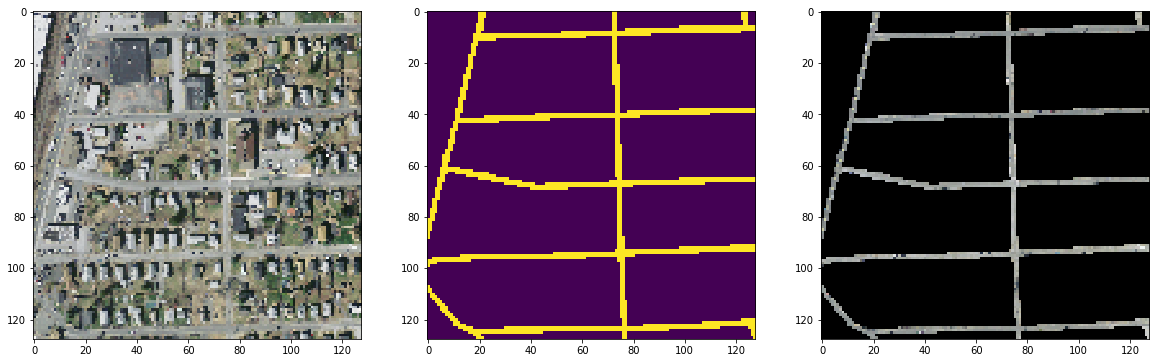

In [80]:
f = random.choice(train_ids)

display_image(f, 'train', tile_size)

In [81]:
#f = '23579050_15_2'
map_output_file = f'{OUTPUT_PATH_PNG}/train/map/{f}.png'
mask_img = Image.open(map_output_file)
np.asarray(mask_img)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0,   0, 255]], dtype=uint8)

In [82]:
np.count_nonzero(np.asarray(mask_img))

1935

In [84]:
rndf = [random.choice(train_ids) for i in range(0,16)]
rndf

['21028945_15_7',
 '22228915_15_8',
 '23579035_15_10',
 '25529260_15_4',
 '17878930_15_1',
 '22678870_15_8',
 '22229005_15_13',
 '10978750_15_2',
 '17728855_15_2',
 '24478840_15_3',
 '22828915_15_12',
 '22378960_15_10',
 '23428930_15_14',
 '23278945_15_10',
 '17578930_15_15',
 '22229020_15_7']

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)